In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

###### Загружаем данные

In [2]:
df_money = pd.read_csv("Money.csv")

In [3]:
df_abgroup = pd.read_csv("ABgroup.csv")

In [4]:
df_cash = pd.read_csv("Cash.csv")

In [5]:
df_cheaters = pd.read_csv("Cheaters.csv")

In [6]:
df_platforms = pd.read_csv("Platforms.csv")

In [7]:
df_abgroup.sort_values('user_id')

,user_id,group
516029,00036L-1T885I,control
4282472,00036L-1T885I,control
1530349,00036L-1T885I,control
4015064,00036L-1T885I,control
4841272,00036L-1T885I,control
...,...,...
522760,ZZZVH1-2OJT7I,control
777139,ZZZVH1-2OJT7I,control
8528190,ZZZVH1-2OJT7I,control
7827472,ZZZVH1-2OJT7I,control


In [9]:
len(df_cheaters[df_cheaters['cheaters'] == 1])/8

353.0

Количество выявленных читеров (353).

In [10]:
len(df_abgroup[df_abgroup['group'] == 'test'])/8

539653.0

Количество в группе тестируемых (539 653 чел).

In [11]:
len(df_abgroup[df_abgroup['group'] == 'control'])/8

540347.0

Количество в контрольной группе, без изм (540 347 чел).

In [12]:
len(df_abgroup[df_abgroup['group'] == 'control'])/8 - len(df_abgroup[df_abgroup['group'] == 'test'])/8

694.0

Контрольная группа больше тестируемой на 694 человека (выявленных читеров в исх данных = 353 чел):
Вычистим данные. Соединим две таблицы cash и cheaters, и для начала исключим тех user_id которые на этапе теста определены как читеры.

In [13]:
# Датафрейм с пользователями-читерами, выявленными до проведения теста
cheat_1 = df_cheaters[df_cheaters['cheaters'] == 1].groupby('user_id').count()
# получена таблица с начисленными объемами внутренней валюты выявленных читеров ДО:
cheat_1_cash = pd.merge(cheat_1, df_cash, how = 'left', left_on='user_id', right_on='user_id')

In [14]:
# сумма объемов начисленной внутр валюты за 8 дней по каждому ранее выявленному читеру
sum_cheat_1 = cheat_1_cash.groupby('user_id').agg('sum')[['cash']].sort_values('cash')
sum_cheat_1

,cash
user_id,
GLGM0P-VMHL3W,46700
3WOSJF-UC2DAO,50150
IALNLO-F5DDS6,55800
9YG4CS-DIEGHQ,70300
AYLSIY-0XGKR5,70700
...,...
57T98Z-SYFLSH,222950
N9HQS0-Y2L88S,226500
VTOLQS-23AL7R,231750


Видим, что объемы начисления внутриигровой валюты с помощью взлома по ранее выявленным читерам варьируются от 46700 до 253150 у.е. по каждому из читеров (суммарно за рассматриваемый период 8 дней).
Далее перейдем к поиску пока не выявленных читеров.

In [15]:
# Датафрейм с пользователями-"не читерами" (с учетом не выявленных пока читеров)
cheat_2 = df_cheaters[df_cheaters['cheaters'] == 0].groupby('user_id').count()
cheat_2

,cheaters
user_id,
00036L-1T885I,8
0004MK-MRBUKF,8
0004MK-VW0O9L,8
0005S4-UEC6BE,8
0007I5-EWUD6O,8
...,...
ZZZPEX-P2T8BH,8
ZZZTEN-0QGZ3X,8
ZZZTR5-QSI6D3,8


Получен перечень cheat_2 уникальных user_id из 1079647 чел не читеров (в т.ч. пока не выявленные).

In [16]:
# Датафрейм с пользователями-"не читерами" (с учетом не выявленных пока читеров)
cheat_2 = df_cheaters[df_cheaters['cheaters'] == 0].groupby('user_id').count()
# получена табл с начисленными объемами внутр валюты НЕ читерам (в т.ч. пока не выявленным):
notcheat_cash = pd.merge(cheat_2, df_cash, how = 'left', left_on='user_id', right_on='user_id') 
notcheat_cash = notcheat_cash.groupby('user_id').agg('sum')[['cash']]
notcheat_cash.sort_values('cash')

,cash
user_id,
DTU9N4-QS35SQ,50
INBV7M-9S58NQ,50
4KAX70-CHAJX2,50
S6F3GG-MUGQG3,100
2CJYT7-AXT4GP,100
...,...
BZRZ88-435FHY,225650
OCRQ1L-GZH0BP,230600
BGTT4M-1ZFLMA,235100


Видим, что разброс велик, от 50 до 240950 у.е. суммарно по каждому игроку за рассматриваемый период. 
Очевидно, что требуется выявить читеров и убрать их из списка для последующей оценки эффективности проведения ab-теста.
Передем к поиску читеров (аномалий). Рассмотрим точечные оценки выборки трат внутриигровой валюты нечитерами 
(в т.ч. пока не выявленными читерами).

In [18]:
def basic_research (df = notcheat_cash, column = 'cash'):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")
    print("Самые популярные значения cash, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    sns.distplot(df[column])
    plt.title("Распределение трат внутриигровой валюты по игрокам")

Базовые метрики
count    1.079647e+06
mean     6.061209e+03
std      3.004201e+03
min      5.000000e+01
25%      5.050000e+03
50%      6.000000e+03
75%      6.950000e+03
max      2.409500e+05
Name: cash, dtype: float64
------------------------------------
Самые популярные значения cash, топ 5
6050    15629
6000    15600
5850    15510
6100    15501
5900    15499
Name: cash, dtype: int64
------------------------------------


C:\ProgramData\Jupyter notebook\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


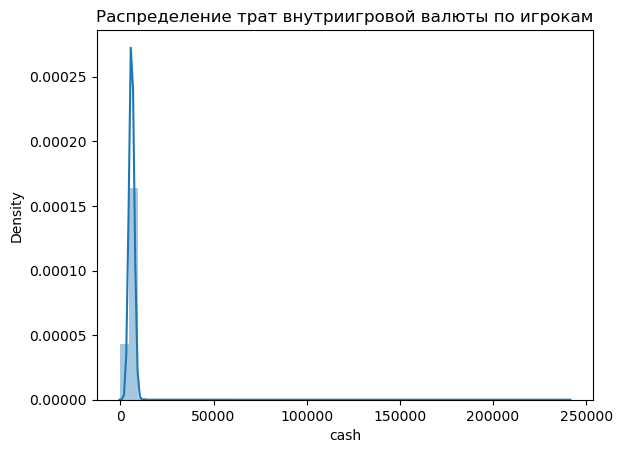

In [19]:
basic_research()

In [20]:
# рассчитаем moda (самые популярные значения) объем внутр валюты по НЕ читерам 
# (в т.ч. пока не выявленным)
notcheat_cash['cash'].value_counts().nlargest(5)

6050    15629
6000    15600
5850    15510
6100    15501
5900    15499
Name: cash, dtype: int64

In [21]:
# рассчитаем median объем внутр валюты по НЕ читерам (в т.ч. пока не выявленным)
notcheat_cash['cash'].median()

6000.0

In [22]:
notcheat_cash['cash'].describe()

count    1.079647e+06
mean     6.061209e+03
std      3.004201e+03
min      5.000000e+01
25%      5.050000e+03
50%      6.000000e+03
75%      6.950000e+03
max      2.409500e+05
Name: cash, dtype: float64

Text(0.5, 1.0, 'Распределение V внутр валюты, полученной НЕ читерами (в т.ч. пока не выявленным)')

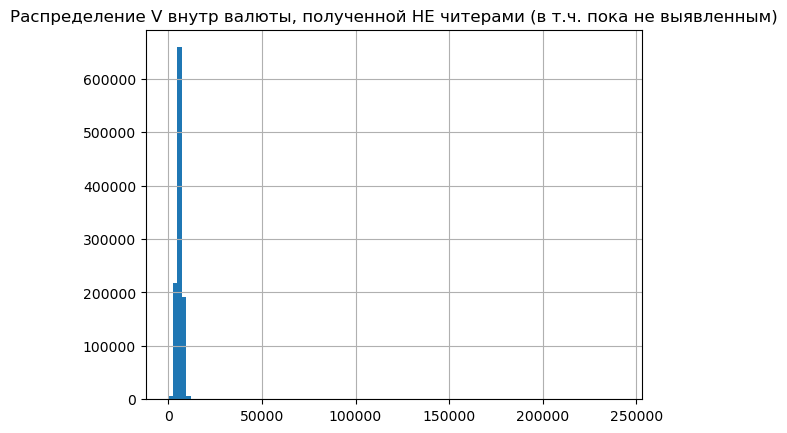

In [23]:
# построим гистограмму распределения
notcheat_cash['cash'].hist(bins = 100)
plt.title('Распределение V внутр валюты, полученной НЕ читерами (в т.ч. пока не выявленным)')

Очевидно, что распредление cash ассиметричное (наличие читеров в нем делает диаграмму смещенной в право).

Text(0.5, 1.0, 'Распределение V внутр валюты, полученной НЕ читерами (в т.ч. пока не выявленным)')

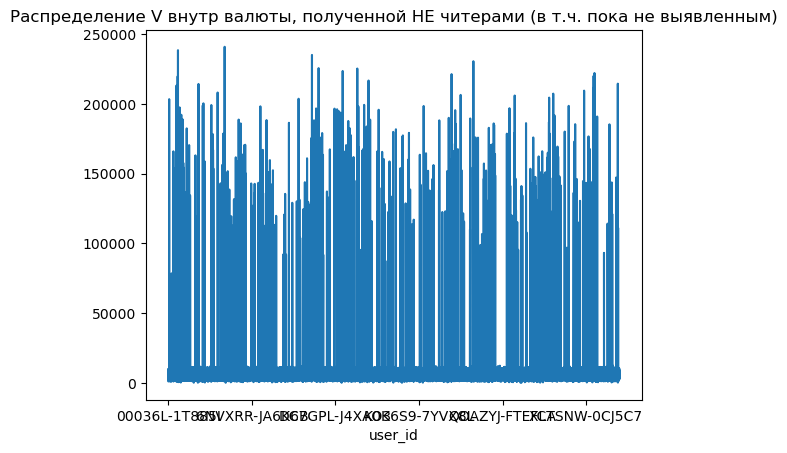

In [24]:
notcheat_cash['cash'].plot()
plt.title('Распределение V внутр валюты, полученной НЕ читерами (в т.ч. пока не выявленным)')

Построим график QQ plot (который сравнивает квантили еашей выборки и квантили нормального распределения 
с таким же средним и сигмой)

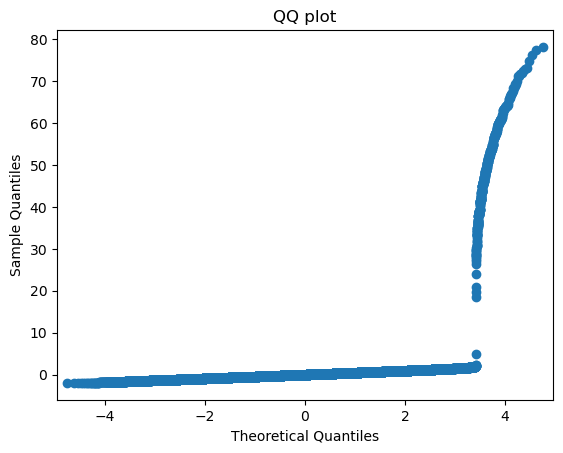

In [25]:
sm.qqplot(notcheat_cash['cash'], fit = True)
plt.title('QQ plot')
plt.show()

Видим, что у нас не очевидно нормальное распредление, график в начале не под 45 градусов, но вторая часть графика 
похожа на норм распредление. Построим доверительный интервал.

In [26]:
def my_norm_confidence(df=notcheat_cash, column='cash', alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale = df[column].std())
    return interval

In [27]:
confidence = my_norm_confidence()
print(confidence)

(173.08327322169953, 11949.334517037525)


Text(0.5, 1.0, 'Доверительный интервал')

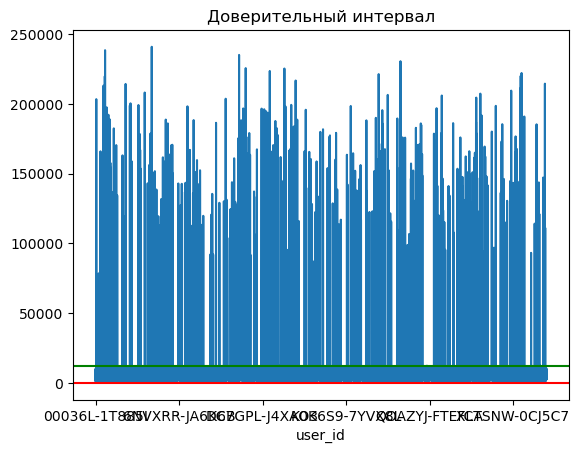

In [28]:
notcheat_cash['cash'].plot()
plt.axhline(y = confidence[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Все, что выше верхней границы доверительного интервала = 11949, можно смело называть аномалией или,в нашем конкретном случае, - проделки читеров. Отметим читеров (аномальные события, выходящие за верхнюю зеленую границу).

In [29]:
notcheat_cash['anomaly_big'] = np.where(notcheat_cash['cash'] > confidence[1], 1, 0)

In [30]:
found_cheaters = notcheat_cash[notcheat_cash['anomaly_big'] == 1]
found_cheaters.describe()

,cash,anomaly_big
count,362.000000,362.0
mean,144094.889503,1.0
std,45314.555978,0.0
min,11950.000000,1.0
25%,122362.500000,1.0
50%,147525.000000,1.0
75%,171387.500000,1.0
max,240950.000000,1.0


In [31]:
found_cheaters.sort_values('cash')

,cash,anomaly_big
user_id,,
ALMETB-LKZNKD,11950,1
CXDLR8-JWHVG3,11950,1
HWMZBD-41YY42,11950,1
BT8G1W-PLFH3I,12000,1
QBD342-S7QOW4,12000,1
...,...,...
BZRZ88-435FHY,225650,1
OCRQ1L-GZH0BP,230600,1
BGTT4M-1ZFLMA,235100,1


С помощью доверительного интервала выявлены и отобраны 362 читера. Итого, с учетом выявленных ранее 353 читеров, 
сумма всех читеров составила = 715 читеров. А теперь получим пользователей НЕ читеров.

In [32]:
notcheat = notcheat_cash[notcheat_cash['anomaly_big'] == 0]
notcheat.sort_values('user_id')

,cash,anomaly_big
user_id,,
00036L-1T885I,7600,0
0004MK-MRBUKF,6150,0
0004MK-VW0O9L,6300,0
0005S4-UEC6BE,5000,0
0007I5-EWUD6O,6350,0
...,...,...
ZZZPEX-P2T8BH,6600,0
ZZZTEN-0QGZ3X,4600,0
ZZZTR5-QSI6D3,5900,0


Проверим вычищенный список на норм распредeление.

Text(0.5, 1.0, 'Распределение V внутр валюты, полученной НЕ читерами')

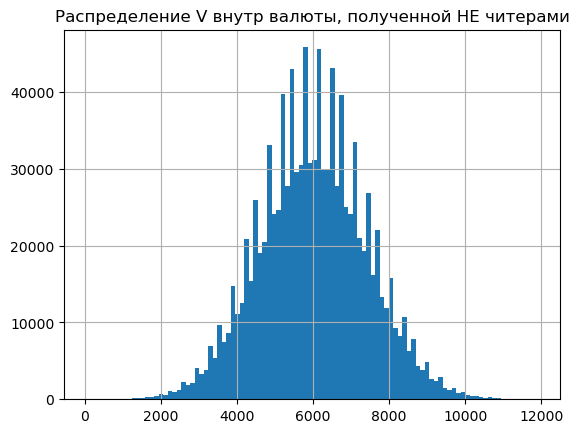

In [33]:
# построим гистограмму распределения
notcheat['cash'].hist(bins = 100)
plt.title('Распределение V внутр валюты, полученной НЕ читерами')

Text(0.5, 1.0, 'Распределение V внутр валюты, полученной НЕ читерами')

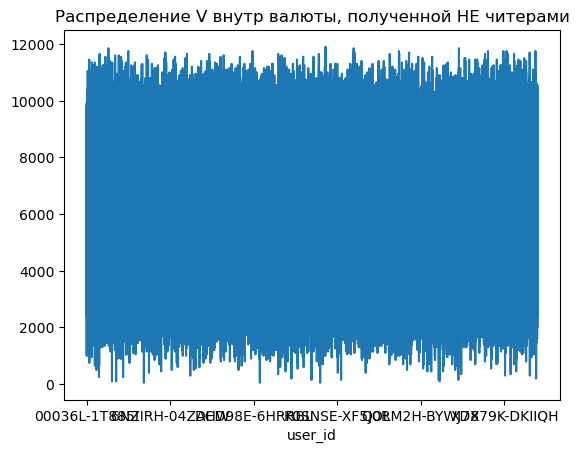

In [34]:
notcheat['cash'].plot()
plt.title('Распределение V внутр валюты, полученной НЕ читерами')

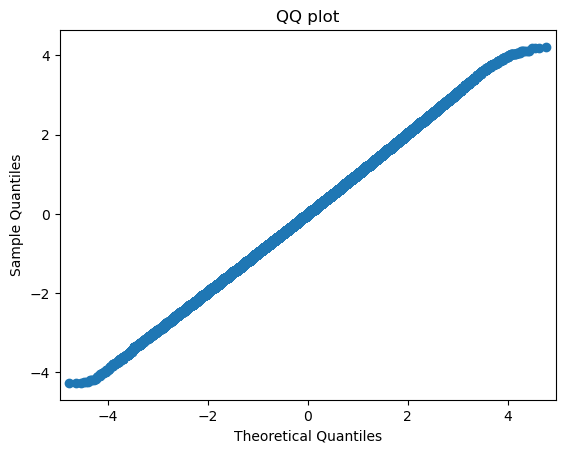

In [35]:
# построим график QQ plot
sm.qqplot(notcheat['cash'], fit = True)
plt.title('QQ plot')
plt.show()

Теперь видим, что данные очень близки к Гауссову распределению, график под 45 градусов.Данные по игрокам вычищены 
от читеров для дальнейшего проведения анализа a/b-тестирования.

In [36]:
notcheat.sort_values('user_id')

,cash,anomaly_big
user_id,,
00036L-1T885I,7600,0
0004MK-MRBUKF,6150,0
0004MK-VW0O9L,6300,0
0005S4-UEC6BE,5000,0
0007I5-EWUD6O,6350,0
...,...,...
ZZZPEX-P2T8BH,6600,0
ZZZTEN-0QGZ3X,4600,0
ZZZTR5-QSI6D3,5900,0


Оставим в табл notcheat только перечень неповторяющихся user_id игроков - не читеров (удалим столбцы anomaly_big и cash).

In [37]:
notcheat = notcheat.drop(columns=['anomaly_big', 'cash']) 
notcheat

""
user_id
00036L-1T885I
0004MK-MRBUKF
0004MK-VW0O9L
0005S4-UEC6BE
0007I5-EWUD6O
...
ZZZPEX-P2T8BH
ZZZTEN-0QGZ3X
ZZZTR5-QSI6D3


Разделим датафрейм df_platforms на 3 по видам игровых платформ.

In [38]:
df_platforms.groupby('platform').agg('count')

,user_id
platform,
PC,2881992
PS4,2873752
XBox,2884256


Подготовим сводный датафрейм с данными по платежам и второй с тратами внутренней валюты пользователей площадки PC.

In [39]:
# Датафрейм с уникальным перечнем user_id РС игровой платформы
user_PC = df_platforms[df_platforms['platform'] == 'PC'].groupby('user_id').agg('count')

In [40]:
user_PC = user_PC.drop('platform', 1)
user_PC['platform'] = 'PC'
user_PC

C:\Users\Аня\AppData\Local\Temp\ipykernel_15844\3962336163.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  user_PC = user_PC.drop('platform', 1)


,platform
user_id,
0004MK-VW0O9L,PC
0005S4-UEC6BE,PC
0007I5-EWUD6O,PC
000GCO-EY0QBQ,PC
000GOD-0KXGY5,PC
...,...
ZZZC9G-FQ4ABS,PC
ZZZIS2-9EYJF3,PC
ZZZONB-1W7QEW,PC


In [41]:
# соединим таблицы user_PC и табл notcheat (с user_id = "не читерами"), 
# получим перечень уникальных user_id PC без читеров:
user_PC1 = pd.merge(user_PC, notcheat, left_on='user_id', right_on='user_id') 
user_PC1

,platform
user_id,
0004MK-VW0O9L,PC
0005S4-UEC6BE,PC
0007I5-EWUD6O,PC
000GCO-EY0QBQ,PC
000GOD-0KXGY5,PC
...,...
ZZZC9G-FQ4ABS,PC
ZZZIS2-9EYJF3,PC
ZZZONB-1W7QEW,PC


Добавим данные ab-group по "не читерам" площадки PC.

In [42]:
abgroup = df_abgroup.groupby('user_id').agg('max')[['group']]
abgroup

,group
user_id,
00036L-1T885I,control
0004MK-MRBUKF,control
0004MK-VW0O9L,test
0005S4-UEC6BE,test
0007I5-EWUD6O,test
...,...
ZZZPEX-P2T8BH,test
ZZZTEN-0QGZ3X,test
ZZZTR5-QSI6D3,test


In [43]:
user_PC_group = pd.merge(user_PC1, abgroup, left_on='user_id', right_on='user_id') 
user_PC_group.sort_values('user_id')

,platform,group
user_id,,
0004MK-VW0O9L,PC,test
0005S4-UEC6BE,PC,test
0007I5-EWUD6O,PC,test
000GCO-EY0QBQ,PC,control
000GOD-0KXGY5,PC,control
...,...,...
ZZZC9G-FQ4ABS,PC,test
ZZZIS2-9EYJF3,PC,test
ZZZONB-1W7QEW,PC,test


Добавим в сводный датафрейм по PC (user_PC_group) данные по платежам.

In [44]:
PC_money = pd.merge(user_PC_group, df_money, left_on='user_id', right_on='user_id') 
PC_money.sort_values(['user_id', 'date']).head(20)

,user_id,platform,group,date,money
1,0004MK-VW0O9L,PC,test,10.07.2021,0.00
3,0004MK-VW0O9L,PC,test,11.07.2021,0.00
6,0004MK-VW0O9L,PC,test,12.07.2021,0.00
2,0004MK-VW0O9L,PC,test,13.07.2021,0.99
0,0004MK-VW0O9L,PC,test,14.07.2021,1.99
4,0004MK-VW0O9L,PC,test,15.07.2021,0.99
7,0004MK-VW0O9L,PC,test,16.07.2021,0.00
5,0004MK-VW0O9L,PC,test,17.07.2021,0.99
12,0005S4-UEC6BE,PC,test,10.07.2021,0.99
11,0005S4-UEC6BE,PC,test,11.07.2021,1.99


Добавим в сводный датафрейм по PC (user_PC_group) данные по тратам внутриигровой валюты.

In [45]:
PC_cash = pd.merge(user_PC_group, df_cash, left_on='user_id', right_on='user_id') 
PC_cash.sort_values(['user_id', 'date']).head(20)

,user_id,platform,group,date,cash
4,0004MK-VW0O9L,PC,test,10.07.2021,0
1,0004MK-VW0O9L,PC,test,11.07.2021,50
0,0004MK-VW0O9L,PC,test,12.07.2021,550
6,0004MK-VW0O9L,PC,test,13.07.2021,1450
3,0004MK-VW0O9L,PC,test,14.07.2021,1250
7,0004MK-VW0O9L,PC,test,15.07.2021,1550
5,0004MK-VW0O9L,PC,test,16.07.2021,900
2,0004MK-VW0O9L,PC,test,17.07.2021,550
13,0005S4-UEC6BE,PC,test,10.07.2021,1200
9,0005S4-UEC6BE,PC,test,11.07.2021,1050


Получены два датафрейма PC_money, PC_cash по площадке PC для дальнейшего анализа результатов ab-теста.
Подготовим сводный датафрейм с данными по платежам и второй с тратами внутренней валюты пользователей площадки PS4.

In [46]:
# Датафрейм с уникальным перечнем user_id PS4 игровой платформы
user_PS4 = df_platforms[df_platforms['platform'] == 'PS4'].groupby('user_id').agg('count')
user_PS4

,platform
user_id,
0004MK-MRBUKF,8
000A88-I8NCEL,8
000B68-JX82RN,8
000FGL-B0RMB9,8
000IF8-UU506H,8
...,...
ZZZF7J-O80D44,8
ZZZIL3-5TLJT0,8
ZZZL1P-5DBOHS,8


In [47]:
user_PS4 = user_PS4.drop('platform', 1)
user_PS4['platform'] = 'PS4'
user_PS4

C:\Users\Аня\AppData\Local\Temp\ipykernel_15844\769916331.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  user_PS4 = user_PS4.drop('platform', 1)


,platform
user_id,
0004MK-MRBUKF,PS4
000A88-I8NCEL,PS4
000B68-JX82RN,PS4
000FGL-B0RMB9,PS4
000IF8-UU506H,PS4
...,...
ZZZF7J-O80D44,PS4
ZZZIL3-5TLJT0,PS4
ZZZL1P-5DBOHS,PS4


In [48]:
# соединим таблицы user_PS4 и табл notcheat (с user_id = "не читерами"), 
# получим перечень уникальных user_id PS4 без читеров:
user_PS4_1 = pd.merge(user_PS4, notcheat, left_on='user_id', right_on='user_id') 
user_PS4_1

,platform
user_id,
0004MK-MRBUKF,PS4
000A88-I8NCEL,PS4
000B68-JX82RN,PS4
000FGL-B0RMB9,PS4
000IF8-UU506H,PS4
...,...
ZZZF7J-O80D44,PS4
ZZZIL3-5TLJT0,PS4
ZZZL1P-5DBOHS,PS4


Добавим данные ab-group по "не читерам" площадки PS4.

In [49]:
user_PS4_group = pd.merge(user_PS4_1, abgroup, left_on='user_id', right_on='user_id') 
user_PS4_group.sort_values('user_id')

,platform,group
user_id,,
0004MK-MRBUKF,PS4,control
000A88-I8NCEL,PS4,control
000B68-JX82RN,PS4,control
000FGL-B0RMB9,PS4,control
000IF8-UU506H,PS4,test
...,...,...
ZZZF7J-O80D44,PS4,test
ZZZIL3-5TLJT0,PS4,test
ZZZL1P-5DBOHS,PS4,control


Добавим в сводный датафрейм по PS4 (user_PS4_group) данные по платежам.

In [50]:
PS4_money = pd.merge(user_PS4_group, df_money, left_on='user_id', right_on='user_id') 
PS4_money.sort_values(['user_id', 'date']).head(20)

,user_id,platform,group,date,money
1,0004MK-MRBUKF,PS4,control,10.07.2021,0.00
2,0004MK-MRBUKF,PS4,control,11.07.2021,1.99
4,0004MK-MRBUKF,PS4,control,12.07.2021,0.99
6,0004MK-MRBUKF,PS4,control,13.07.2021,0.99
5,0004MK-MRBUKF,PS4,control,14.07.2021,0.99
0,0004MK-MRBUKF,PS4,control,15.07.2021,0.99
7,0004MK-MRBUKF,PS4,control,16.07.2021,0.00
3,0004MK-MRBUKF,PS4,control,17.07.2021,0.00
11,000A88-I8NCEL,PS4,control,10.07.2021,0.99
13,000A88-I8NCEL,PS4,control,11.07.2021,0.99


Добавим в сводный датафрейм по PS4 (user_PS4_group) данные по тратам внутриигровой валюты.

In [51]:
PS4_cash = pd.merge(user_PS4_group, df_cash, left_on='user_id', right_on='user_id') 
PS4_cash.sort_values(['user_id', 'date']).head(20)

,user_id,platform,group,date,cash
2,0004MK-MRBUKF,PS4,control,10.07.2021,550
6,0004MK-MRBUKF,PS4,control,11.07.2021,1100
4,0004MK-MRBUKF,PS4,control,12.07.2021,1350
7,0004MK-MRBUKF,PS4,control,13.07.2021,50
5,0004MK-MRBUKF,PS4,control,14.07.2021,250
1,0004MK-MRBUKF,PS4,control,15.07.2021,1350
3,0004MK-MRBUKF,PS4,control,16.07.2021,700
0,0004MK-MRBUKF,PS4,control,17.07.2021,800
11,000A88-I8NCEL,PS4,control,10.07.2021,150
10,000A88-I8NCEL,PS4,control,11.07.2021,200


Получены два датафрейма PS4_money, PS4_cash по площадке PC для дальнейшего анализа результатов ab-теста.
Подготовим сводный датафрейм с данными по платежам и второй с тратами внутренней валюты пользователей площадки XBox.

In [52]:
# Датафрейм с уникальным перечнем user_id XBox игровой платформы
user_XBox = df_platforms[df_platforms['platform'] == 'XBox'].groupby('user_id').agg('count')
user_XBox

,platform
user_id,
00036L-1T885I,8
0009DN-TWTJIG,8
000B9M-CLSPQD,8
000F5V-PDHPGB,8
000IP5-YWFJUK,8
...,...
ZZZ6L1-Y6RHU9,8
ZZZ6UB-ON8WFC,8
ZZZ91E-MFSYMW,8


In [53]:
user_XBox = user_XBox.drop('platform', 1)
user_XBox['platform'] = 'XBox'
user_XBox

C:\Users\Аня\AppData\Local\Temp\ipykernel_15844\2045362758.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  user_XBox = user_XBox.drop('platform', 1)


,platform
user_id,
00036L-1T885I,XBox
0009DN-TWTJIG,XBox
000B9M-CLSPQD,XBox
000F5V-PDHPGB,XBox
000IP5-YWFJUK,XBox
...,...
ZZZ6L1-Y6RHU9,XBox
ZZZ6UB-ON8WFC,XBox
ZZZ91E-MFSYMW,XBox


In [54]:
# соединим таблицы user_XBox и табл notcheat (с user_id = "не читерами"), 
# получим перечень уникальных user_id XBox без читеров:
user_XBox1 = pd.merge(user_XBox, notcheat, left_on='user_id', right_on='user_id') 
user_XBox1

,platform
user_id,
00036L-1T885I,XBox
0009DN-TWTJIG,XBox
000B9M-CLSPQD,XBox
000F5V-PDHPGB,XBox
000IP5-YWFJUK,XBox
...,...
ZZZ6L1-Y6RHU9,XBox
ZZZ6UB-ON8WFC,XBox
ZZZ91E-MFSYMW,XBox


Добавим данные ab-group по "не читерам" площадки XBox.

In [55]:
user_XBox_group = pd.merge(user_XBox1, abgroup, left_on='user_id', right_on='user_id') 
user_XBox_group.sort_values('user_id')

,platform,group
user_id,,
00036L-1T885I,XBox,control
0009DN-TWTJIG,XBox,control
000B9M-CLSPQD,XBox,control
000F5V-PDHPGB,XBox,control
000IP5-YWFJUK,XBox,control
...,...,...
ZZZ6L1-Y6RHU9,XBox,test
ZZZ6UB-ON8WFC,XBox,control
ZZZ91E-MFSYMW,XBox,test


Добавим в сводный датафрейм по XBox (user_XBox_group) данные по платежам.

In [56]:
XBox_money = pd.merge(user_XBox_group, df_money, left_on='user_id', right_on='user_id') 
XBox_money.sort_values(['user_id', 'date']).head(20)

,user_id,platform,group,date,money
0,00036L-1T885I,XBox,control,10.07.2021,0.00
2,00036L-1T885I,XBox,control,11.07.2021,0.00
3,00036L-1T885I,XBox,control,12.07.2021,0.99
6,00036L-1T885I,XBox,control,13.07.2021,0.00
4,00036L-1T885I,XBox,control,14.07.2021,0.00
7,00036L-1T885I,XBox,control,15.07.2021,0.00
1,00036L-1T885I,XBox,control,16.07.2021,0.99
5,00036L-1T885I,XBox,control,17.07.2021,1.99
8,0009DN-TWTJIG,XBox,control,10.07.2021,0.99
11,0009DN-TWTJIG,XBox,control,11.07.2021,0.00


Добавим в сводный датафрейм по XBox (user_XBox_group) данные по тратам внутриигровой валюты.

In [57]:
XBox_cash = pd.merge(user_XBox_group, df_cash, left_on='user_id', right_on='user_id') 
XBox_cash.sort_values(['user_id', 'date']).head(20)

,user_id,platform,group,date,cash
5,00036L-1T885I,XBox,control,10.07.2021,700
1,00036L-1T885I,XBox,control,11.07.2021,0
3,00036L-1T885I,XBox,control,12.07.2021,1500
2,00036L-1T885I,XBox,control,13.07.2021,850
4,00036L-1T885I,XBox,control,14.07.2021,650
6,00036L-1T885I,XBox,control,15.07.2021,700
0,00036L-1T885I,XBox,control,16.07.2021,550
7,00036L-1T885I,XBox,control,17.07.2021,2650
12,0009DN-TWTJIG,XBox,control,10.07.2021,950
10,0009DN-TWTJIG,XBox,control,11.07.2021,50


Получены два датафрейма XBox_money, XBox_cash по площадке XBox для дальнейшего анализа результатов ab-теста.
Итого получены 6 датафреймов (по 2 для каждой игровой площадки) для расчета метрик ARPU, ARPPU, 
трат внутриигровой валюты и построения доверительных итервалов.

Таким образом, основная часть читеров на игровой платформе PC (707 чел), 3 читера на PS4 и 5 читеров на платформе XBox.
Получим два датафрейма ab_money, ab_cash по всем игровым площадкам для дальнейшего анализа результатов ab-теста.

In [58]:
platforms = df_platforms.groupby('user_id').agg('max')[['platform']]

In [59]:
abgroup = df_abgroup.groupby('user_id').agg('max')[['group']]

In [61]:
# соединим таблицы platforms и табл notcheat (с user_id = "не читерами"), 
# получим перечень уникальных user_id без читеров с указанием платформы:
users_platforms = pd.merge(notcheat, platforms, left_on='user_id', right_on='user_id') 
users_platforms

,platform
user_id,
00036L-1T885I,XBox
0004MK-MRBUKF,PS4
0004MK-VW0O9L,PC
0005S4-UEC6BE,PC
0007I5-EWUD6O,PC
...,...
ZZZPEX-P2T8BH,PC
ZZZTEN-0QGZ3X,XBox
ZZZTR5-QSI6D3,XBox


Добавим данные ab-group по "не читерам".

In [62]:
users_group = pd.merge(users_platforms, abgroup, left_on='user_id', right_on='user_id') 
users_group.sort_values('user_id')

,platform,group
user_id,,
00036L-1T885I,XBox,control
0004MK-MRBUKF,PS4,control
0004MK-VW0O9L,PC,test
0005S4-UEC6BE,PC,test
0007I5-EWUD6O,PC,test
...,...,...
ZZZPEX-P2T8BH,PC,test
ZZZTEN-0QGZ3X,XBox,test
ZZZTR5-QSI6D3,XBox,test


In [63]:
users_group.sort_values('user_id')

,platform,group
user_id,,
00036L-1T885I,XBox,control
0004MK-MRBUKF,PS4,control
0004MK-VW0O9L,PC,test
0005S4-UEC6BE,PC,test
0007I5-EWUD6O,PC,test
...,...,...
ZZZPEX-P2T8BH,PC,test
ZZZTEN-0QGZ3X,XBox,test
ZZZTR5-QSI6D3,XBox,test


Добавим в сводный датафрейм по всем игровым площадкам (users_group) данные по платежам.

In [64]:
ab_money = pd.merge(users_group, df_money, left_on='user_id', right_on='user_id') 
ab_money.sort_values(['user_id', 'date']).head(10)

,user_id,platform,group,date,money
0,00036L-1T885I,XBox,control,10.07.2021,0.00
2,00036L-1T885I,XBox,control,11.07.2021,0.00
3,00036L-1T885I,XBox,control,12.07.2021,0.99
6,00036L-1T885I,XBox,control,13.07.2021,0.00
4,00036L-1T885I,XBox,control,14.07.2021,0.00
7,00036L-1T885I,XBox,control,15.07.2021,0.00
1,00036L-1T885I,XBox,control,16.07.2021,0.99
5,00036L-1T885I,XBox,control,17.07.2021,1.99
9,0004MK-MRBUKF,PS4,control,10.07.2021,0.00
10,0004MK-MRBUKF,PS4,control,11.07.2021,1.99


Добавим в сводный датафрейм по всем игровым площадкам (users_group) данные по тратам внутриигровой валюты.

In [65]:
ab_cash = pd.merge(users_group, df_cash, left_on='user_id', right_on='user_id') 
ab_cash.sort_values(['user_id', 'date']).head(10)

,user_id,platform,group,date,cash
5,00036L-1T885I,XBox,control,10.07.2021,700
1,00036L-1T885I,XBox,control,11.07.2021,0
3,00036L-1T885I,XBox,control,12.07.2021,1500
2,00036L-1T885I,XBox,control,13.07.2021,850
4,00036L-1T885I,XBox,control,14.07.2021,650
6,00036L-1T885I,XBox,control,15.07.2021,700
0,00036L-1T885I,XBox,control,16.07.2021,550
7,00036L-1T885I,XBox,control,17.07.2021,2650
10,0004MK-MRBUKF,PS4,control,10.07.2021,550
14,0004MK-MRBUKF,PS4,control,11.07.2021,1100


Итого получены 2 датафреймa для расчета метрик ARPU, ARPPU, трат внутриигровой валюты и построения доверительных итервалов.

In [66]:
len(ab_money[ab_money['group'] == 'test'])/8

539295.0

In [67]:
len(ab_money[ab_money['group'] == 'control'])/8

539990.0

1. Рассчитаем и сравним метрики для площадки PC.

1.1. Рассчитаем ARPU(средняя прибыль на игрока) для двух групп на платформе PC.

Чтобы уменьшить загрузку системы, сделаю предварительное разделение таблиц ab_money, ab_cash по типам игровых платформ.

In [68]:
len(ab_money[(ab_money['platform'] == 'PC') & (ab_money['group'] == 'test')])/8

179810.0

In [69]:
len(ab_money[(ab_money['platform'] == 'PC') & (ab_money['group'] == 'control')])/8

179732.0

In [70]:
PC_test_m = ab_money[(ab_money['platform'] == 'PC') & (ab_money['group'] == 'test')]
ARPU_PC_test = PC_test_m.groupby('date').agg('mean')[['money']]
ARPU_PC_test.rename(columns={'money': 'AR_t_PC'}, inplace=True)
ARPU_PC_test

,AR_t_PC
date,
10.07.2021,0.783128
11.07.2021,0.782359
12.07.2021,0.779498
13.07.2021,0.762110
14.07.2021,0.723891
15.07.2021,0.669944
16.07.2021,0.591685
17.07.2021,1.176109


In [71]:
PC_control_m = ab_money[(ab_money['platform'] == 'PC') & (ab_money['group'] == 'control')]
ARPU_PC_control = PC_control_m.groupby('date').agg('mean')[['money']]
ARPU_PC_control.rename(columns={'money': 'AR_c_PC'}, inplace=True)
ARPU_PC_control

,AR_c_PC
date,
10.07.2021,0.716623
11.07.2021,0.712882
12.07.2021,0.712218
13.07.2021,0.697021
14.07.2021,0.660105
15.07.2021,0.605105
16.07.2021,0.539199
17.07.2021,1.003050


Соединим в один df ARPU для двух групп площадки PC и рассчитаем эффект в %.

In [72]:
ARPU_PC = pd.merge(ARPU_PC_test, ARPU_PC_control, left_on='date', right_on='date') 
ARPU_PC['perc_PC'] = ARPU_PC['AR_t_PC'] / ARPU_PC['AR_c_PC'] * 100 - 100
ARPU_PC = ARPU_PC.round({'AR_t_PC': 3, 'AR_c_PC': 3, 'perc_PC': 1})
ARPU_PC

,AR_t_PC,AR_c_PC,perc_PC
date,,,
10.07.2021,0.783,0.717,9.3
11.07.2021,0.782,0.713,9.7
12.07.2021,0.779,0.712,9.4
13.07.2021,0.762,0.697,9.3
14.07.2021,0.724,0.660,9.7
15.07.2021,0.670,0.605,10.7
16.07.2021,0.592,0.539,9.7
17.07.2021,1.176,1.003,17.3


1.2. Рассчитаем ARPPU(средняя прибыль на платящего игрока) для двух групп на платформе PC.

In [73]:
PC_test_m_2 = ab_money[(ab_money['platform'] == 'PC') & (ab_money['group'] == 'test') 
                       & (ab_money['money'] > 0)]
ARPPU_PC_test = PC_test_m_2.groupby('date').agg('mean')[['money']]
ARPPU_PC_test.rename(columns={'money': 'ARPP_t_PC'}, inplace=True)
ARPPU_PC_test

,ARPP_t_PC
date,
10.07.2021,1.229014
11.07.2021,1.228665
12.07.2021,1.227936
13.07.2021,1.223538
14.07.2021,1.210682
15.07.2021,1.193456
16.07.2021,1.162589
17.07.2021,1.952850


In [74]:
PC_control_m_2 = ab_money[(ab_money['platform'] == 'PC') 
                          & (ab_money['group'] == 'control') & (ab_money['money'] > 0)]
ARPPU_PC_control = PC_control_m_2.groupby('date').agg('mean')[['money']]
ARPPU_PC_control.rename(columns={'money': 'ARPP_c_PC'}, inplace=True)
ARPPU_PC_control

,ARPP_c_PC
date,
10.07.2021,1.208324
11.07.2021,1.207180
12.07.2021,1.208013
13.07.2021,1.202228
14.07.2021,1.187632
15.07.2021,1.169024
16.07.2021,1.137776
17.07.2021,1.737037


In [75]:
ARPPU_PC = pd.merge(ARPPU_PC_test, ARPPU_PC_control, left_on='date', right_on='date') 
ARPPU_PC['perc_ARPP'] = ARPPU_PC['ARPP_t_PC'] / ARPPU_PC['ARPP_c_PC'] * 100 - 100
ARPPU_PC = ARPPU_PC.round({'ARPP_t_PC': 3, 'ARPP_c_PC': 3, 'perc_ARPP': 1})
ARPPU_PC

,ARPP_t_PC,ARPP_c_PC,perc_ARPP
date,,,
10.07.2021,1.229,1.208,1.7
11.07.2021,1.229,1.207,1.8
12.07.2021,1.228,1.208,1.6
13.07.2021,1.224,1.202,1.8
14.07.2021,1.211,1.188,1.9
15.07.2021,1.193,1.169,2.1
16.07.2021,1.163,1.138,2.2
17.07.2021,1.953,1.737,12.4


1.3. Рассмотрим траты внутриигровой валюты для двух групп на платформе PC.

In [76]:
PC_test_с = ab_cash[(ab_cash['platform'] == 'PC') & (ab_money['group'] == 'test')]
cash_PC_test = PC_test_с.groupby('date').agg('mean')[['cash']]
cash_PC_test.rename(columns={'cash': 'cash_t'}, inplace=True)
cash_PC_test

,cash_t
date,
10.07.2021,848.749791
11.07.2021,848.166954
12.07.2021,843.568211
13.07.2021,822.536288
14.07.2021,768.223959
15.07.2021,677.086925
16.07.2021,546.502141
17.07.2021,1026.585006


In [77]:
PC_control_с = ab_cash[(ab_cash['platform'] == 'PC') & (ab_money['group'] == 'control')]
cash_PC_control = PC_control_с.groupby('date').agg('mean')[['cash']]
cash_PC_control.rename(columns={'cash': 'cash_c'}, inplace=True)
cash_PC_control

,cash_c
date,
10.07.2021,749.532916
11.07.2021,748.794316
12.07.2021,745.380344
13.07.2021,726.588198
14.07.2021,679.558454
15.07.2021,593.840830
16.07.2021,478.081254
17.07.2021,865.325874


Соединим в один df средние по тратам внутренней валюты для двух групп площадки PC и рассчитаем эффект в %.

In [78]:
cash_PC = pd.merge(cash_PC_test, cash_PC_control, left_on='date', right_on='date') 
cash_PC['perc_cash'] = cash_PC_test['cash_t'] / cash_PC_control['cash_c'] * 100 - 100
cash_PC = cash_PC.round({'cash_t': 3, 'cash_c': 3, 'perc_cash': 1})
cash_PC

,cash_t,cash_c,perc_cash
date,,,
10.07.2021,848.750,749.533,13.2
11.07.2021,848.167,748.794,13.3
12.07.2021,843.568,745.380,13.2
13.07.2021,822.536,726.588,13.2
14.07.2021,768.224,679.558,13.0
15.07.2021,677.087,593.841,14.0
16.07.2021,546.502,478.081,14.3
17.07.2021,1026.585,865.326,18.6


Соединим в один df полученные метрики и их сравнение по игровой платформе PC.

In [79]:
PC_metrics = pd.merge(ARPU_PC, ARPPU_PC, left_on='date', right_on='date') 
PC_metrics = pd.merge(PC_metrics, cash_PC, left_on='date', right_on='date') 
PC_metrics

,AR_t_PC,AR_c_PC,perc_PC,ARPP_t_PC,ARPP_c_PC,perc_ARPP,cash_t,cash_c,perc_cash
date,,,,,,,,,
10.07.2021,0.783,0.717,9.3,1.229,1.208,1.7,848.750,749.533,13.2
11.07.2021,0.782,0.713,9.7,1.229,1.207,1.8,848.167,748.794,13.3
12.07.2021,0.779,0.712,9.4,1.228,1.208,1.6,843.568,745.380,13.2
13.07.2021,0.762,0.697,9.3,1.224,1.202,1.8,822.536,726.588,13.2
14.07.2021,0.724,0.660,9.7,1.211,1.188,1.9,768.224,679.558,13.0
15.07.2021,0.670,0.605,10.7,1.193,1.169,2.1,677.087,593.841,14.0
16.07.2021,0.592,0.539,9.7,1.163,1.138,2.2,546.502,478.081,14.3
17.07.2021,1.176,1.003,17.3,1.953,1.737,12.4,1026.585,865.326,18.6


Результаты сравнения метрик ARPU, ARPPU и трат внутриигровой валюты показывают, что приход денег от игроков группы участников, которые учавствовали в тестировании, больше второй группы, которая не учавствовала в акции.

2. Рассчитаем и сравним метрики для площадки PS4.

In [80]:
len(ab_money[(ab_money['platform'] == 'PS4') & (ab_money['group'] == 'test')])/8

179412.0

In [81]:
len(ab_money[(ab_money['platform'] == 'PS4') & (ab_money['group'] == 'control')])/8

179804.0

2.1. Рассчитаем ARPU(средняя прибыль на игрока) для двух групп на платформе PS4.

In [82]:
PS4_test_m = ab_money[(ab_money['platform'] == 'PS4') & (ab_money['group'] == 'test')]
ARPU_PS4_test = PS4_test_m.groupby('date').agg('mean')[['money']]
ARPU_PS4_test.rename(columns={'money': 'AR_t_PS4'}, inplace=True)
ARPU_PS4_test

,AR_t_PS4
date,
10.07.2021,0.749762
11.07.2021,0.752693
12.07.2021,0.747309
13.07.2021,0.734541
14.07.2021,0.702888
15.07.2021,0.647921
16.07.2021,0.577642
17.07.2021,1.172002


In [83]:
PS4_control_m = ab_money[(ab_money['platform'] == 'PS4') & (ab_money['group'] == 'control')]
ARPU_PS4_control = PS4_control_m.groupby('date').agg('mean')[['money']]
ARPU_PS4_control.rename(columns={'money': 'AR_c_PS4'}, inplace=True)
ARPU_PS4_control

,AR_c_PS4
date,
10.07.2021,0.716531
11.07.2021,0.714064
12.07.2021,0.710443
13.07.2021,0.692791
14.07.2021,0.662511
15.07.2021,0.610725
16.07.2021,0.545892
17.07.2021,1.084689


Соединим в один df ARPU для двух групп площадки PS4 и рассчитаем эффект в %.

In [84]:
ARPU_PS4 = pd.merge(ARPU_PS4_test, ARPU_PS4_control, left_on='date', right_on='date') 
ARPU_PS4['perc_PS4'] = ARPU_PS4['AR_t_PS4'] / ARPU_PS4['AR_c_PS4'] * 100 - 100
ARPU_PS4 = ARPU_PS4.round({'AR_t_PS4': 3, 'AR_c_PS4': 3, 'perc_PS4': 1})
ARPU_PS4

,AR_t_PS4,AR_c_PS4,perc_PS4
date,,,
10.07.2021,0.750,0.717,4.6
11.07.2021,0.753,0.714,5.4
12.07.2021,0.747,0.710,5.2
13.07.2021,0.735,0.693,6.0
14.07.2021,0.703,0.663,6.1
15.07.2021,0.648,0.611,6.1
16.07.2021,0.578,0.546,5.8
17.07.2021,1.172,1.085,8.0


2.2. Рассчитаем ARPPU(средняя прибыль на платящего игрока) для двух групп на платформе PS4.

In [85]:
PS4_test_m_2 = ab_money[(ab_money['platform'] == 'PS4') 
                        & (ab_money['group'] == 'test') & (ab_money['money'] > 0)]
ARPPU_PS4_test = PS4_test_m_2.groupby('date').agg('mean')[['money']]
ARPPU_PS4_test.rename(columns={'money': 'ARPP_t_PS4'}, inplace=True)
ARPPU_PS4_test

,ARPP_t_PS4
date,
10.07.2021,1.217706
11.07.2021,1.222189
12.07.2021,1.215758
13.07.2021,1.216215
14.07.2021,1.203892
15.07.2021,1.183478
16.07.2021,1.156470
17.07.2021,1.920653


In [86]:
PS4_control_m_2 = ab_money[(ab_money['platform'] == 'PS4') 
                           & (ab_money['group'] == 'control') & (ab_money['money'] > 0)]
ARPPU_PS4_control = PS4_control_m_2.groupby('date').agg('mean')[['money']]
ARPPU_PS4_control.rename(columns={'money': 'ARPP_c_PS4'}, inplace=True)
ARPPU_PS4_control

,ARPP_c_PS4
date,
10.07.2021,1.207690
11.07.2021,1.207392
12.07.2021,1.206887
13.07.2021,1.200664
14.07.2021,1.190126
15.07.2021,1.170429
16.07.2021,1.142091
17.07.2021,1.823576


Соединим в один df ARPPU для двух групп площадки PS4 и рассчитаем эффект в %.

In [87]:
ARPPU_PS4 = pd.merge(ARPPU_PS4_test, ARPPU_PS4_control, left_on='date', right_on='date') 
ARPPU_PS4['perc_ARPP'] = ARPPU_PS4['ARPP_t_PS4'] / ARPPU_PS4['ARPP_c_PS4'] * 100 - 100
ARPPU_PS4 = ARPPU_PS4.round({'ARPP_t_PS4': 3, 'ARPP_c_PS4': 3, 'perc_ARPP': 1})
ARPPU_PS4

,ARPP_t_PS4,ARPP_c_PS4,perc_ARPP
date,,,
10.07.2021,1.218,1.208,0.8
11.07.2021,1.222,1.207,1.2
12.07.2021,1.216,1.207,0.7
13.07.2021,1.216,1.201,1.3
14.07.2021,1.204,1.190,1.2
15.07.2021,1.183,1.170,1.1
16.07.2021,1.156,1.142,1.3
17.07.2021,1.921,1.824,5.3


2.3. Рассмотрим траты внутриигровой валюты для двух групп на платформе PS4.

In [88]:
PS4_test_с = ab_cash[(ab_cash['platform'] == 'PS4') 
                     & (ab_money['group'] == 'test')]
cash_PS4_test = PS4_test_с.groupby('date').agg('mean')[['cash']]
cash_PS4_test.rename(columns={'cash': 'cash_t'}, inplace=True)
cash_PS4_test

,cash_t
date,
10.07.2021,799.965443
11.07.2021,799.857312
12.07.2021,794.961039
13.07.2021,780.439714
14.07.2021,734.040365
15.07.2021,653.337569
16.07.2021,532.290482
17.07.2021,1035.494839


In [89]:
PS4_control_с = ab_cash[(ab_cash['platform'] == 'PS4') 
                        & (ab_money['group'] == 'control')]
cash_PS4_control = PS4_control_с.groupby('date').agg('mean')[['cash']]
cash_PS4_control.rename(columns={'cash': 'cash_c'}, inplace=True)
cash_PS4_control

,cash_c
date,
10.07.2021,750.971892
11.07.2021,750.073413
12.07.2021,744.970079
13.07.2021,724.261696
14.07.2021,679.014093
15.07.2021,598.475284
16.07.2021,487.905720
17.07.2021,946.263987


Соединим в один df средние по тратам внутренней валюты для двух групп площадки PS4 и рассчитаем эффект в %.

In [90]:
cash_PS4 = pd.merge(cash_PS4_test, cash_PS4_control, left_on='date', right_on='date') 
cash_PS4['perc_cash'] = cash_PS4_test['cash_t'] / cash_PS4_control['cash_c'] * 100 - 100
cash_PS4 = cash_PS4.round({'cash_t': 3, 'cash_c': 3, 'perc_cash': 1})
cash_PS4

,cash_t,cash_c,perc_cash
date,,,
10.07.2021,799.965,750.972,6.5
11.07.2021,799.857,750.073,6.6
12.07.2021,794.961,744.970,6.7
13.07.2021,780.440,724.262,7.8
14.07.2021,734.040,679.014,8.1
15.07.2021,653.338,598.475,9.2
16.07.2021,532.290,487.906,9.1
17.07.2021,1035.495,946.264,9.4


Соединим в один df полученные метрики и их сравнение по игровой платформе PS4.

In [91]:
PS4_metrics = pd.merge(ARPU_PS4, ARPPU_PS4, left_on='date', right_on='date') 
PS4_metrics = pd.merge(PS4_metrics, cash_PS4, left_on='date', right_on='date') 
PS4_metrics

,AR_t_PS4,AR_c_PS4,perc_PS4,ARPP_t_PS4,ARPP_c_PS4,perc_ARPP,cash_t,cash_c,perc_cash
date,,,,,,,,,
10.07.2021,0.750,0.717,4.6,1.218,1.208,0.8,799.965,750.972,6.5
11.07.2021,0.753,0.714,5.4,1.222,1.207,1.2,799.857,750.073,6.6
12.07.2021,0.747,0.710,5.2,1.216,1.207,0.7,794.961,744.970,6.7
13.07.2021,0.735,0.693,6.0,1.216,1.201,1.3,780.440,724.262,7.8
14.07.2021,0.703,0.663,6.1,1.204,1.190,1.2,734.040,679.014,8.1
15.07.2021,0.648,0.611,6.1,1.183,1.170,1.1,653.338,598.475,9.2
16.07.2021,0.578,0.546,5.8,1.156,1.142,1.3,532.290,487.906,9.1
17.07.2021,1.172,1.085,8.0,1.921,1.824,5.3,1035.495,946.264,9.4


3. Рассчитаем и сравним метрики для площадки XBox.

In [92]:
len(ab_money[(ab_money['platform'] == 'XBox') & (ab_money['group'] == 'test')])/8

180073.0

In [93]:
len(ab_money[(ab_money['platform'] == 'XBox') & (ab_money['group'] == 'control')])/8

180454.0

3.1. Рассчитаем ARPU(средняя прибыль на игрока) для двух групп на платформе XBox.

In [94]:
XBox_test_m = ab_money[(ab_money['platform'] == 'XBox') 
                       & (ab_money['group'] == 'test')]
ARPU_XBox_test = XBox_test_m.groupby('date').agg('mean')[['money']]
ARPU_XBox_test.rename(columns={'money': 'AR_t_Xb'}, inplace=True)
ARPU_XBox_test

,AR_t_Xb
date,
10.07.2021,0.749682
11.07.2021,0.750862
12.07.2021,0.748736
13.07.2021,0.733677
14.07.2021,0.703851
15.07.2021,0.648705
16.07.2021,0.580732
17.07.2021,1.216388


In [95]:
XBox_control_m = ab_money[(ab_money['platform'] == 'XBox') 
                          & (ab_money['group'] == 'control')]
ARPU_XBox_control = XBox_control_m.groupby('date').agg('mean')[['money']]
ARPU_XBox_control.rename(columns={'money': 'AR_c_Xb'}, inplace=True)
ARPU_XBox_control

,AR_c_Xb
date,
10.07.2021,0.754951
11.07.2021,0.753413
12.07.2021,0.748329
13.07.2021,0.736472
14.07.2021,0.702397
15.07.2021,0.648233
16.07.2021,0.576121
17.07.2021,1.183584


Соединим в один df ARPU для двух групп площадки XBox и рассчитаем эффект в %.

In [96]:
ARPU_XBox = pd.merge(ARPU_XBox_test, ARPU_XBox_control, left_on='date', right_on='date') 
ARPU_XBox['perc_Xb'] = ARPU_XBox['AR_t_Xb'] / ARPU_XBox['AR_c_Xb'] * 100 - 100
ARPU_XBox = ARPU_XBox.round({'AR_t_Xb': 3, 'AR_c_Xb': 3, 'perc_Xb': 1})
ARPU_XBox

,AR_t_Xb,AR_c_Xb,perc_Xb
date,,,
10.07.2021,0.750,0.755,-0.7
11.07.2021,0.751,0.753,-0.3
12.07.2021,0.749,0.748,0.1
13.07.2021,0.734,0.736,-0.4
14.07.2021,0.704,0.702,0.2
15.07.2021,0.649,0.648,0.1
16.07.2021,0.581,0.576,0.8
17.07.2021,1.216,1.184,2.8


3.2. Рассчитаем ARPPU(средняя прибыль на платящего игрока) для двух групп на платформе XBox.

In [97]:
XBox_test_m_2 = ab_money[(ab_money['platform'] == 'XBox') 
                         & (ab_money['group'] == 'test') & (ab_money['money'] > 0)]
ARPPU_XBox_test = XBox_test_m_2.groupby('date').agg('mean')[['money']]
ARPPU_XBox_test.rename(columns={'money': 'ARPP_t_Xb'}, inplace=True)
ARPPU_XBox_test

,ARPP_t_Xb
date,
10.07.2021,1.218895
11.07.2021,1.217997
12.07.2021,1.220232
13.07.2021,1.214810
14.07.2021,1.205357
15.07.2021,1.186233
16.07.2021,1.156921
17.07.2021,1.963679


In [98]:
XBox_control_m_2 = ab_money[(ab_money['platform'] == 'XBox') 
                            & (ab_money['group'] == 'control') & (ab_money['money'] > 0)]
ARPPU_XBox_control = XBox_control_m_2.groupby('date').agg('mean')[['money']]
ARPPU_XBox_control.rename(columns={'money': 'ARPP_c_Xb'}, inplace=True)
ARPPU_XBox_control

,ARPP_c_Xb
date,
10.07.2021,1.220724
11.07.2021,1.218629
12.07.2021,1.218642
13.07.2021,1.215135
14.07.2021,1.204027
15.07.2021,1.186660
16.07.2021,1.154405
17.07.2021,1.935377


Соединим в один df ARPPU для двух групп площадки XBox и рассчитаем эффект в %.

In [99]:
ARPPU_XBox = pd.merge(ARPPU_XBox_test, ARPPU_XBox_control, left_on='date', right_on='date') 
ARPPU_XBox['perc_ARPP'] = ARPPU_XBox['ARPP_t_Xb'] / ARPPU_XBox['ARPP_c_Xb'] * 100 - 100
ARPPU_XBox = ARPPU_XBox.round({'ARPP_t_Xb': 3, 'ARPP_c_Xb': 3, 'perc_ARPP': 1})
ARPPU_XBox

,ARPP_t_Xb,ARPP_c_Xb,perc_ARPP
date,,,
10.07.2021,1.219,1.221,-0.1
11.07.2021,1.218,1.219,-0.1
12.07.2021,1.220,1.219,0.1
13.07.2021,1.215,1.215,-0.0
14.07.2021,1.205,1.204,0.1
15.07.2021,1.186,1.187,-0.0
16.07.2021,1.157,1.154,0.2
17.07.2021,1.964,1.935,1.5


3.3. Рассмотрим траты внутриигровой валюты для двух групп на платформе XBox.

In [100]:
XBox_test_с = ab_cash[(ab_cash['platform'] == 'XBox') 
                      & (ab_money['group'] == 'test')]
cash_XBox_test = XBox_test_с.groupby('date').agg('mean')[['cash']]
cash_XBox_test.rename(columns={'cash': 'cash_t'}, inplace=True)
cash_XBox_test

,cash_t
date,
10.07.2021,798.724129
11.07.2021,800.720819
12.07.2021,795.484054
13.07.2021,777.966991
14.07.2021,737.204911
15.07.2021,651.932272
16.07.2021,537.520894
17.07.2021,1076.714999


In [101]:
XBox_control_с = ab_cash[(ab_cash['platform'] == 'XBox') 
                         & (ab_money['group'] == 'control')]
cash_XBox_control = XBox_control_с.groupby('date').agg('mean')[['cash']]
cash_XBox_control.rename(columns={'cash': 'cash_c'}, inplace=True)
cash_XBox_control

,cash_c
date,
10.07.2021,801.320004
11.07.2021,800.393175
12.07.2021,795.143915
13.07.2021,778.911800
14.07.2021,732.770955
15.07.2021,648.520953
16.07.2021,530.738027
17.07.2021,1043.960511


Соединим в один df средние по тратам внутренней валюты для двух групп площадки XBox и рассчитаем эффект в %.

In [102]:
cash_XBox = pd.merge(cash_XBox_test, cash_XBox_control, left_on='date', right_on='date') 
cash_XBox['perc_cash'] = cash_XBox_test['cash_t'] / cash_XBox_control['cash_c'] * 100 - 100
cash_XBox = cash_XBox.round({'cash_t': 3, 'cash_c': 3, 'perc_cash': 1})
cash_XBox

,cash_t,cash_c,perc_cash
date,,,
10.07.2021,798.724,801.320,-0.3
11.07.2021,800.721,800.393,0.0
12.07.2021,795.484,795.144,0.0
13.07.2021,777.967,778.912,-0.1
14.07.2021,737.205,732.771,0.6
15.07.2021,651.932,648.521,0.5
16.07.2021,537.521,530.738,1.3
17.07.2021,1076.715,1043.961,3.1


Соединим в один df полученные метрики и их сравнение по игровой платформе XBox.

In [103]:
XBox_metrics = pd.merge(ARPU_XBox, ARPPU_XBox, left_on='date', right_on='date') 
XBox_metrics = pd.merge(XBox_metrics, cash_XBox, left_on='date', right_on='date') 
XBox_metrics

,AR_t_Xb,AR_c_Xb,perc_Xb,ARPP_t_Xb,ARPP_c_Xb,perc_ARPP,cash_t,cash_c,perc_cash
date,,,,,,,,,
10.07.2021,0.750,0.755,-0.7,1.219,1.221,-0.1,798.724,801.320,-0.3
11.07.2021,0.751,0.753,-0.3,1.218,1.219,-0.1,800.721,800.393,0.0
12.07.2021,0.749,0.748,0.1,1.220,1.219,0.1,795.484,795.144,0.0
13.07.2021,0.734,0.736,-0.4,1.215,1.215,-0.0,777.967,778.912,-0.1
14.07.2021,0.704,0.702,0.2,1.205,1.204,0.1,737.205,732.771,0.6
15.07.2021,0.649,0.648,0.1,1.186,1.187,-0.0,651.932,648.521,0.5
16.07.2021,0.581,0.576,0.8,1.157,1.154,0.2,537.521,530.738,1.3
17.07.2021,1.216,1.184,2.8,1.964,1.935,1.5,1076.715,1043.961,3.1


Результаты сравнения метрик ARPU, ARPPU и трат внутриигровой валюты показывают, что эффекта акция для платформы XBox 
не принесла. Создадим сводную таблицу с ARPU по группам и платформам и сохраним ее в эксель.

In [104]:
metrics = pd.merge(ARPU_PC, ARPU_PS4, left_on='date', right_on='date')
metrics = pd.merge(metrics, ARPU_XBox, left_on='date', right_on='date')
metrics

,AR_t_PC,AR_c_PC,perc_PC,AR_t_PS4,AR_c_PS4,perc_PS4,AR_t_Xb,AR_c_Xb,perc_Xb
date,,,,,,,,,
10.07.2021,0.783,0.717,9.3,0.750,0.717,4.6,0.750,0.755,-0.7
11.07.2021,0.782,0.713,9.7,0.753,0.714,5.4,0.751,0.753,-0.3
12.07.2021,0.779,0.712,9.4,0.747,0.710,5.2,0.749,0.748,0.1
13.07.2021,0.762,0.697,9.3,0.735,0.693,6.0,0.734,0.736,-0.4
14.07.2021,0.724,0.660,9.7,0.703,0.663,6.1,0.704,0.702,0.2
15.07.2021,0.670,0.605,10.7,0.648,0.611,6.1,0.649,0.648,0.1
16.07.2021,0.592,0.539,9.7,0.578,0.546,5.8,0.581,0.576,0.8
17.07.2021,1.176,1.003,17.3,1.172,1.085,8.0,1.216,1.184,2.8


In [105]:
metrics.to_excel('metrics.xlsx')

Для построения графиков сравнения метрик по дням в Power BI сохраним в excel датафреймы с метриками по каждой из игровых платформ.

In [106]:
PC_metrics.to_excel('PC.xlsx')
PS4_metrics.to_excel('PS4.xlsx')
XBox_metrics.to_excel('XBox.xlsx')

Построим доверительные интервалы от средних значений с точностью 95%.

Начнем с построения доверительных интервалов для метрик игровой платформы PC.

In [107]:
PC_metrics

,AR_t_PC,AR_c_PC,perc_PC,ARPP_t_PC,ARPP_c_PC,perc_ARPP,cash_t,cash_c,perc_cash
date,,,,,,,,,
10.07.2021,0.783,0.717,9.3,1.229,1.208,1.7,848.750,749.533,13.2
11.07.2021,0.782,0.713,9.7,1.229,1.207,1.8,848.167,748.794,13.3
12.07.2021,0.779,0.712,9.4,1.228,1.208,1.6,843.568,745.380,13.2
13.07.2021,0.762,0.697,9.3,1.224,1.202,1.8,822.536,726.588,13.2
14.07.2021,0.724,0.660,9.7,1.211,1.188,1.9,768.224,679.558,13.0
15.07.2021,0.670,0.605,10.7,1.193,1.169,2.1,677.087,593.841,14.0
16.07.2021,0.592,0.539,9.7,1.163,1.138,2.2,546.502,478.081,14.3
17.07.2021,1.176,1.003,17.3,1.953,1.737,12.4,1026.585,865.326,18.6


Доверительный интервал для метрики ARPU на игровой платформе PC.

In [108]:
def my_norm_confidence(df=PC_metrics, column='AR_t_PC', alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale = df[column].std())
    return interval
confidence_t = my_norm_confidence()
print(confidence_t)

(0.44594045103257385, 1.121059548967426)


In [109]:
confidence_c = my_norm_confidence(df=PC_metrics, column='AR_c_PC', alpha = 0.95)
print(confidence_c)

(0.4399892288403603, 0.9715107711596397)


Text(0.5, 1.0, 'Доверительный интервал')

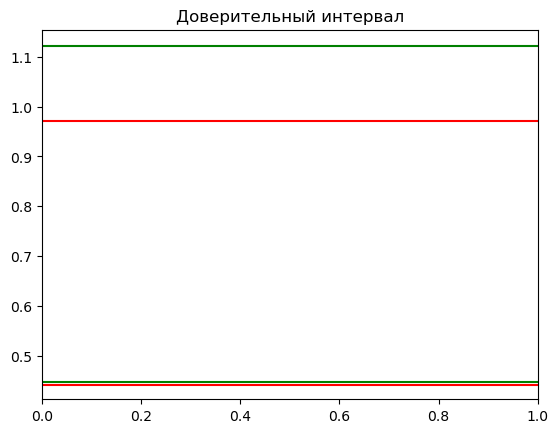

In [110]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Доверительный интервал для метрики ARPPU на игровой платформе PC.

In [111]:
confidence_t = my_norm_confidence(df=PC_metrics, column='ARPP_t_PC', alpha = 0.95)
print(confidence_t)

(0.7875908572344139, 1.819909142765586)


In [112]:
confidence_c = my_norm_confidence(df=PC_metrics, column='ARPP_c_PC', alpha = 0.95)
print(confidence_c)

(0.8740586651515616, 1.6401913348484385)


Text(0.5, 1.0, 'Доверительный интервал')

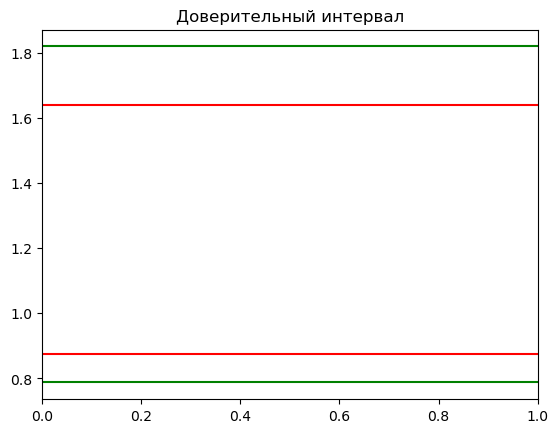

In [113]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Доверительный интервал для метрики траты внутренней валюты на игровой платформе PC.

In [114]:
confidence_t = my_norm_confidence(df=PC_metrics, column='cash_t', alpha = 0.95)
print(confidence_t)

(521.7081366314266, 1073.6466133685735)


In [115]:
confidence_c = my_norm_confidence(df=PC_metrics, column='cash_c', alpha = 0.95)
print(confidence_c)

(469.04171366919445, 927.7335363308057)


Text(0.5, 1.0, 'Доверительный интервал')

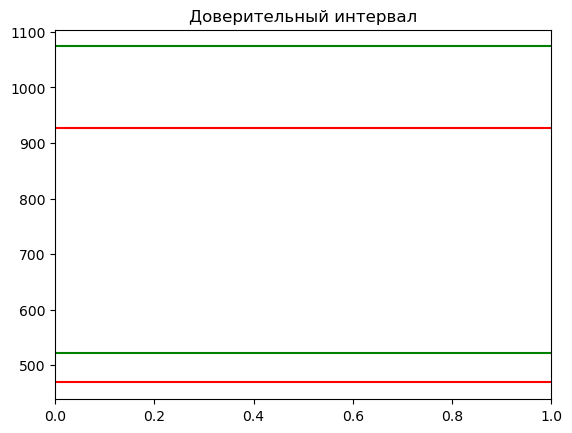

In [116]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Построение доверительных интервалов для метрик игровой платформы PS4.

In [117]:
PS4_metrics

,AR_t_PS4,AR_c_PS4,perc_PS4,ARPP_t_PS4,ARPP_c_PS4,perc_ARPP,cash_t,cash_c,perc_cash
date,,,,,,,,,
10.07.2021,0.750,0.717,4.6,1.218,1.208,0.8,799.965,750.972,6.5
11.07.2021,0.753,0.714,5.4,1.222,1.207,1.2,799.857,750.073,6.6
12.07.2021,0.747,0.710,5.2,1.216,1.207,0.7,794.961,744.970,6.7
13.07.2021,0.735,0.693,6.0,1.216,1.201,1.3,780.440,724.262,7.8
14.07.2021,0.703,0.663,6.1,1.204,1.190,1.2,734.040,679.014,8.1
15.07.2021,0.648,0.611,6.1,1.183,1.170,1.1,653.338,598.475,9.2
16.07.2021,0.578,0.546,5.8,1.156,1.142,1.3,532.290,487.906,9.1
17.07.2021,1.172,1.085,8.0,1.921,1.824,5.3,1035.495,946.264,9.4


Доверительный интервал для метрики ARPU на игровой платформе PS4.

In [118]:
confidence_t = my_norm_confidence(df=PS4_metrics, column='AR_t_PS4', alpha = 0.95)
print(confidence_t)

(0.4136019384850691, 1.1078980615149308)


In [119]:
confidence_c = my_norm_confidence(df=PS4_metrics, column='AR_c_PS4', alpha = 0.95)
print(confidence_c)

(0.4035622020293427, 1.0311877979706572)


Text(0.5, 1.0, 'Доверительный интервал')

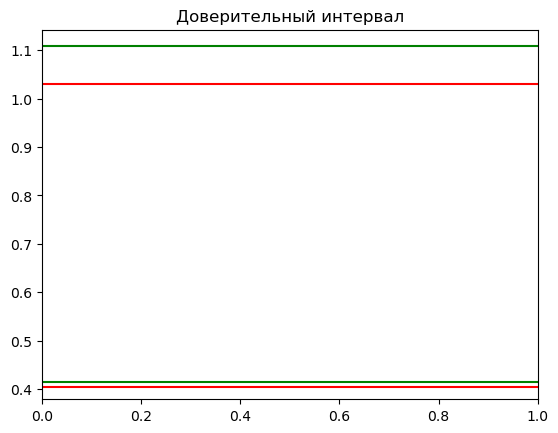

In [120]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Доверительный интервал для метрики ARPPU на игровой платформе PS4.

In [121]:
confidence_t = my_norm_confidence(df=PS4_metrics, column='ARPP_t_PS4', alpha = 0.95)
print(confidence_t)

(0.7919265239698545, 1.792073476030145)


In [122]:
confidence_c = my_norm_confidence(df=PS4_metrics, column='ARPP_c_PS4', alpha = 0.95)
print(confidence_c)

(0.8264817277137623, 1.7107682722862374)


Text(0.5, 1.0, 'Доверительный интервал')

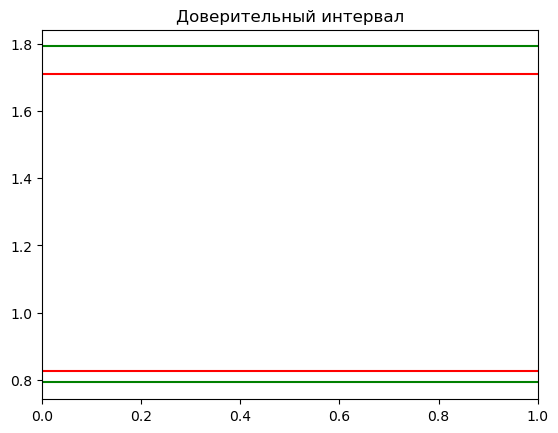

In [123]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Доверительный интервал для метрики траты внутренней валюты на игровой платформе PS4.

In [124]:
confidence_t = my_norm_confidence(df=PS4_metrics, column='cash_t', alpha = 0.95)
print(confidence_t)

(484.8846404526884, 1047.7118595473116)


In [125]:
confidence_c = my_norm_confidence(df=PS4_metrics, column='cash_c', alpha = 0.95)
print(confidence_c)

(450.16560633355783, 970.3183936664423)


Text(0.5, 1.0, 'Доверительный интервал')

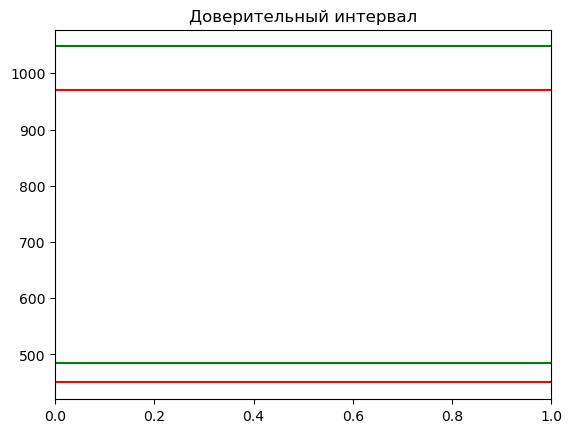

In [126]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Построение доверительных интервалов для метрик игровой платформы XBox.

In [127]:
XBox_metrics

,AR_t_Xb,AR_c_Xb,perc_Xb,ARPP_t_Xb,ARPP_c_Xb,perc_ARPP,cash_t,cash_c,perc_cash
date,,,,,,,,,
10.07.2021,0.750,0.755,-0.7,1.219,1.221,-0.1,798.724,801.320,-0.3
11.07.2021,0.751,0.753,-0.3,1.218,1.219,-0.1,800.721,800.393,0.0
12.07.2021,0.749,0.748,0.1,1.220,1.219,0.1,795.484,795.144,0.0
13.07.2021,0.734,0.736,-0.4,1.215,1.215,-0.0,777.967,778.912,-0.1
14.07.2021,0.704,0.702,0.2,1.205,1.204,0.1,737.205,732.771,0.6
15.07.2021,0.649,0.648,0.1,1.186,1.187,-0.0,651.932,648.521,0.5
16.07.2021,0.581,0.576,0.8,1.157,1.154,0.2,537.521,530.738,1.3
17.07.2021,1.216,1.184,2.8,1.964,1.935,1.5,1076.715,1043.961,3.1


Доверительный интервал для метрики ARPU на игровой платформе XBox.

In [128]:
confidence_t = my_norm_confidence(df=XBox_metrics, column='AR_t_Xb', alpha = 0.95)
print(confidence_t)

(0.39189842415551057, 1.1416015758444893)


In [129]:
confidence_c = my_norm_confidence(df=XBox_metrics, column='AR_c_Xb', alpha = 0.95)
print(confidence_c)

(0.4072651866319726, 1.1182348133680273)


Text(0.5, 1.0, 'Доверительный интервал')

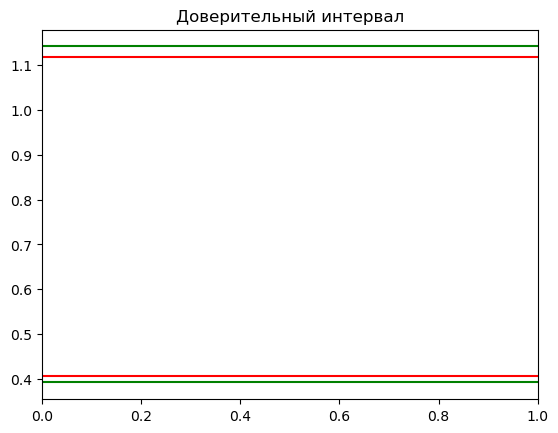

In [130]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Доверительный интервал для метрики ARPPU на игровой платформе XBox.

In [131]:
confidence_t = my_norm_confidence(df=XBox_metrics, column='ARPP_t_Xb', alpha = 0.95)
print(confidence_t)

(0.7688387614743157, 1.8271612385256844)


In [132]:
confidence_c = my_norm_confidence(df=XBox_metrics, column='ARPP_c_Xb', alpha = 0.95)
print(confidence_c)

(0.7848481262814473, 1.803651873718553)


Text(0.5, 1.0, 'Доверительный интервал')

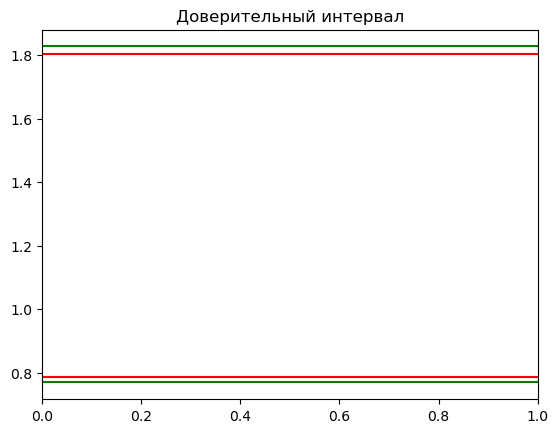

In [134]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')

Доверительный интервал для метрики траты внутренней валюты на игровой платформе XBox.

In [135]:
confidence_t = my_norm_confidence(df=XBox_metrics, column='cash_t', alpha = 0.95)
print(confidence_t)

(470.5877674552469, 1073.4794825447532)


In [136]:
confidence_c = my_norm_confidence(df=XBox_metrics, column='cash_c', alpha = 0.95)
print(confidence_c)

(478.6433242160981, 1054.296675783902)


Text(0.5, 1.0, 'Доверительный интервал')

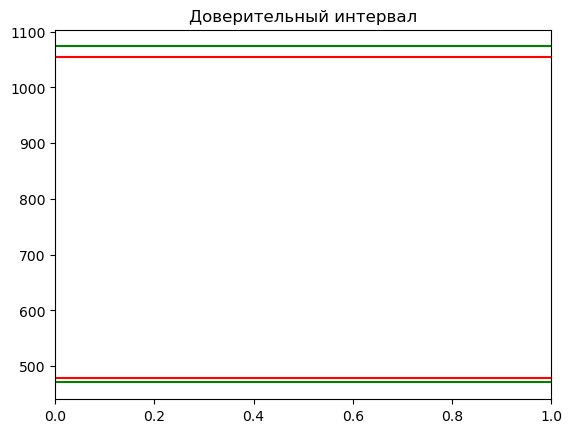

In [137]:
plt.axhline(y = confidence_t[1], color = 'g', linestyle = '-')
plt.axhline(y = confidence_t[0], color = 'g', linestyle = '-')
plt.axhline(y = confidence_c[1], color = 'r', linestyle = '-')
plt.axhline(y = confidence_c[0], color = 'r', linestyle = '-')
plt.title('Доверительный интервал')